# Benchmark hospitals

## Aims

* Predict thrombolysis decisions for a 10k cohort of patients at all hospitals
* Select top 30 hospitals (highest redicted thrombolysis use in 10k cohort). This is the 'benchmark' set of hospitals.
* Predict decision of those benchmark set of hospitals for all patients at each hopsital. Use a majority vote to classify as whether the patient would receive thrombolysis or not.
* Compare actual thrombolysis use with thrombolysis use if decisions made by majority vote of benchmark hospitals.

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Import libraries 

In [2]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.lines import Line2D

from sklearn.ensemble import RandomForestClassifier

## Load pre-trained hospital models into dictionary *hospital2model* 

keys = hospitals

values = trained_classifier, threshold, patients, outcomes

In [3]:
with open ('./models/trained_hospital_models.pkl', 'rb') as f:
    
    hospital2model = pkl.load(f)

## Import 10k cohort

10k cohort all arrive at hospital within 4 hours of known stroke onset

In [4]:
cohort = pd.read_csv('../data/10k_training_test/cohort_10000_test.csv')

## Pass cohort through all hospital models

Allow for new analysis or used loaded resulkts from previous analysis.

In [5]:
hospitals = list(set(cohort['StrokeTeam'].values))

# Set re_analyse to run analysis again, else loads saved data
re_analyse = False

if re_analyse:
    
    # Get decisions for 10k patients at each hospital
    
    y_test = cohort['S2Thrombolysis']
    X_test =  cohort.drop(['StrokeTeam', 'S2Thrombolysis'], axis=1)   

    results = pd.DataFrame()

    for hospital_train in hospitals:

        model, threshold, _, _ = hospital2model[hospital_train]

        y_prob = model.predict_proba(X_test)[:,1]

        y_pred = [1 if p >= threshold else 0 for p in y_prob]

        results[hospital_train] = y_pred
        
    results.to_csv('./predictions/10k_decisions.csv', index=False)
    
else:
    results = pd.read_csv('./predictions/10k_decisions.csv')

In [6]:
results

,TQQYU0036V,JHDQL1362V,JXJYG0100P,LFPMM4706C,JADBS8258F,MHMYL4920B,NZECY6641V,VZOCK3505U,NTPQZ0829K,JRXDG8181O,...,QOAPO4699N,SBRDX1922J,CYVHC2532V,AGNOF1041H,AOBTM3098N,ISXKM9668U,SBYTE4026H,LGNPK4211W,UALFR2142B,RDVPJ0375X
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,1,1,1,1,1,1,...,1,1,1,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,1,1,1,1,1,...,1,1,1,1,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
9997,0,1,0,0,1,1,1,1,1,1,...,1,0,0,1,0,0,0,0,1,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Summarise results

In [7]:
hospital_compare = pd.DataFrame()

hospital_compare['hospital'] = hospitals

hospital_compare['true_rate'] = [
    sum(hospital2model[h][-1])*100/len(hospital2model[h][-1]) for h in hospitals]

hospital_compare['cohort_rate'] = [
    sum(results[h].values)*100/10000 for h in hospitals]

hospital_compare['ratio'] = \
    hospital_compare['cohort_rate'] / hospital_compare['true_rate']

# Label top 30 corhort thrombolysis as benchmark
hospital_compare.sort_values('cohort_rate', inplace=True, ascending=False)
top_30 = [True for x in range(30)]
top_30.extend([False for x in range(len(hospitals)-30)])
hospital_compare['benchmark'] = top_30

In [8]:
hospital_compare

,hospital,true_rate,cohort_rate,ratio,benchmark
109,VKKDD9172T,28.305235,50.70,1.791188,True
91,TPXYE0168D,31.578947,48.04,1.521267,True
130,CNBGF2713O,48.148148,43.30,0.899308,True
2,NTPQZ0829K,34.910486,42.82,1.226566,True
120,GKONI0110I,38.906752,42.53,1.093126,True
...,...,...,...,...,...
96,LGNPK4211W,22.654462,12.76,0.563244,False
10,ISXKM9668U,9.569378,12.76,1.333420,False
77,XPABC1435F,21.768707,12.10,0.555844,False
58,VVDIY0129H,19.130435,10.41,0.544159,False


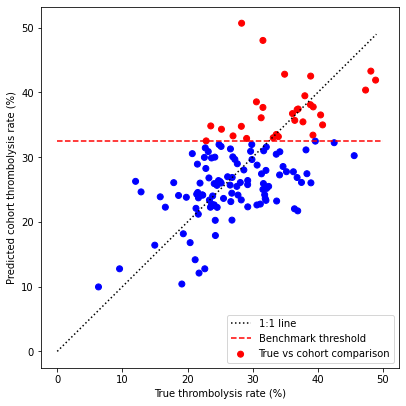

In [9]:
fig = plt.figure(figsize=(6,6))

# Plot copmparison of True rate vs. Corhort rate
ax1 = fig.add_subplot()


colour = ['r'] * 30
colour.extend(['b'] * (len(hospitals) -30 ))


ax1.scatter(hospital_compare['true_rate'],
            hospital_compare['cohort_rate'],
            color=colour,
            label='True vs cohort comparison')

# Add 1:1 line
xx = np.arange(0,50)
ax1.plot(xx,xx, 'k:', label = '1:1 line')

# Add benchmark threshold
mask = hospital_compare['benchmark']
threshold = hospital_compare[mask]['cohort_rate'].min()

ax1.plot([0, 50], [threshold, threshold], 'r--', label='Benchmark threshold')

ax1.set_xlabel('True thrombolysis rate (%)')
ax1.set_ylabel('Predicted cohort thrombolysis rate (%)')
ax1.set_title('')

ax1.legend(loc='lower right')

plt.tight_layout(pad=2)
plt.savefig('./output/benchmark_cohort_with_threshold.jpg', dpi=300)
plt.show()

## Take majority decision of benchmark hospitals  

In [10]:
benchmark_hospitals = hospital_compare['hospital'][0:30]
np.save('./models/benchmark_hospitals.npy', benchmark_hospitals)

In [11]:
# Set re_analyse to run analysis again, else loads saved data
re_analyse = False

if re_analyse:

    columns = \
        np.concatenate((['Hospital','True', 'Majority'], benchmark_hospitals)) 

    results_30 = pd.DataFrame(columns = columns)


    for i, hospital in enumerate(hospitals):
        
        # Show progress
        print(f'Hospital {i+1} of {len(hospitals)}', end='\r')

        # Get hospital model
        _, _, X, y = hospital2model[hospital]

        # Get hospital level results
        hospital_results = pd.DataFrame(columns = columns)           

        # Loop through benchmark hospitals
        for j, top_hospital in enumerate(benchmark_hospitals):
            model, threshold, _, _ = hospital2model[top_hospital]
            y_prob = model.predict_proba(X)[:,1]
            y_pred = [1 if p >= threshold else 0 for p in y_prob]
            hospital_results[top_hospital] = y_pred
        
        # Add to results
        hospital_results['Hospital'] = [hospital for person in y]
        hospital_results['True'] = y
        results_30 = results_30.append(hospital_results, ignore_index=True)
                  
    # Add majority decsion
    majority_threshold = 15/30
    for index,row in results_30.iterrows():
        no = sum([1 for val in row[3:].values if val ==0])
        yes = sum(row[3:].values)
        if yes/(no+yes)>=majority_threshold:
            results_30.loc[index, 'Majority'] = 1
        else:
            results_30.loc[index, 'Majority'] = 0

    results_30.to_csv('./predictions/benchmark_decisions.csv', index=False)
    
else:
    # Load previous results
    results_30 = pd.read_csv('./predictions/benchmark_decisions.csv')

In [12]:
results_30.head()

,Hospital,True,Majority,VKKDD9172T,TPXYE0168D,CNBGF2713O,NTPQZ0829K,GKONI0110I,HPWIF9956L,MHMYL4920B,...,OHGIK1804X,UWCEW6851O,VZOCK3505U,TPFFP4410O,NGKDE7265L,LZGVG8257A,VKHPY9501A,GWOXR9160G,QZMCK3259S,OFKDF3720W
0,HONZP0443O,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HONZP0443O,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HONZP0443O,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HONZP0443O,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HONZP0443O,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


### Repeat analysis just for patients scanned within 4 hours of onset

This value is used in the pathway simulation model.

In [13]:
# Set re_analyse to run analysis again, else loads saved data
re_analyse = False

if re_analyse:

    columns = \
        np.concatenate((['Hospital','True', 'Majority'], benchmark_hospitals)) 

    results_30_4_hr_scan = pd.DataFrame(columns = columns)


    for i, hospital in enumerate(hospitals):
        
        # Show progress
        print(f'Hospital {i+1} of {len(hospitals)}', end='\r')

        # Get hospital model
        _, _, X, y = hospital2model[hospital]
        
        # Limit to those scanned in 4 hours from onset
        onset_scan = X[:, 1] + X[:, 19]
        mask = onset_scan <= 240
        X = X[mask]
        y = y[mask]

        # Get hospital level results
        hospital_results = pd.DataFrame(columns = columns)           

        # Loop through benchmark hospitals
        for j, top_hospital in enumerate(benchmark_hospitals):
            model, threshold, _, _ = hospital2model[top_hospital]
            y_prob = model.predict_proba(X)[:,1]
            y_pred = [1 if p >= threshold else 0 for p in y_prob]
            hospital_results[top_hospital] = y_pred
        
        # Add to results
        hospital_results['Hospital'] = [hospital for person in y]
        hospital_results['True'] = y
        results_30_4_hr_scan = \
            results_30_4_hr_scan.append(hospital_results, ignore_index=True)
                  
    # Add majority decsion
    majority_threshold = 15/30
    for index,row in results_30_4_hr_scan.iterrows():
        no = sum([1 for val in row[3:].values if val ==0])
        yes = sum(row[3:].values)
        if yes/(no+yes)>=majority_threshold:
            results_30_4_hr_scan.loc[index, 'Majority'] = 1
        else:
            results_30_4_hr_scan.loc[index, 'Majority'] = 0

    results_30_4_hr_scan.to_csv(
        './predictions/benchmark_decisions_4_hr_scan.csv', index=False)
    
else:
    # Load previous results
    results_30_4_hr_scan = pd.read_csv(
        './predictions/benchmark_decisions_4_hr_scan.csv')

In [14]:
results_30_4_hr_scan.head()

,Hospital,True,Majority,VKKDD9172T,TPXYE0168D,CNBGF2713O,NTPQZ0829K,GKONI0110I,HPWIF9956L,MHMYL4920B,...,OHGIK1804X,UWCEW6851O,VZOCK3505U,TPFFP4410O,NGKDE7265L,LZGVG8257A,VKHPY9501A,GWOXR9160G,QZMCK3259S,OFKDF3720W
0,FLVXS2956M,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,FLVXS2956M,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,FLVXS2956M,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,FLVXS2956M,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FLVXS2956M,0,0,0,1,1,1,1,1,0,...,1,0,1,0,0,0,1,0,1,0


### Create summary pivot table

In [15]:
df_pivot = results_30[['Hospital', 'True', 'Majority']].groupby('Hospital')
all_4hr_arrivals = df_pivot.sum() / df_pivot.count()
all_4hr_arrivals['count'] = df_pivot.count()['True']

In [16]:
df_pivot = results_30_4_hr_scan[['Hospital', 'True', 'Majority']].groupby('Hospital')
scan_4hrs_pivot = df_pivot.sum() / df_pivot.count()
scan_4hrs_pivot['count'] = df_pivot.count()['True']

In [17]:
hospital_benchmark_rates = pd.DataFrame()
hospital_benchmark_rates['count_4hr_arrival'] = all_4hr_arrivals['count']
hospital_benchmark_rates['actual_4hr_arrival'] = all_4hr_arrivals['True']
hospital_benchmark_rates['benchmark_4hr_arrival'] = all_4hr_arrivals['Majority']
hospital_benchmark_rates['count_4hr_scan'] = scan_4hrs_pivot['count']
hospital_benchmark_rates['actual_4hr_scan'] = scan_4hrs_pivot['True']
hospital_benchmark_rates['benchmark_4hr_scan'] = scan_4hrs_pivot['Majority']

# Add in whether hospital is in benchmark
benchmark_list = hospital_compare.set_index('hospital')
hospital_benchmark_rates= pd.concat([hospital_benchmark_rates, benchmark_list['benchmark']],axis=1)

hospital_benchmark_rates.to_csv('predictions/hospital_benchmark_rates.csv')
hospital_benchmark_rates

,count_4hr_arrival,actual_4hr_arrival,benchmark_4hr_arrival,count_4hr_scan,actual_4hr_scan,benchmark_4hr_scan,benchmark
AGNOF1041H,773,0.351876,0.479948,700,0.387143,0.527143,False
AKCGO9726K,1268,0.369874,0.350158,1106,0.416817,0.399638,True
AOBTM3098N,520,0.219231,0.326923,414,0.265700,0.398551,False
APXEE8191H,509,0.225933,0.286837,448,0.256696,0.323661,False
ATDID5461S,278,0.241007,0.262590,211,0.317536,0.345972,False
...,...,...,...,...,...,...,...
YPKYH1768F,281,0.245552,0.352313,224,0.308036,0.441964,False
YQMZV4284N,418,0.236842,0.272727,319,0.310345,0.351097,False
ZBVSO0975W,384,0.250000,0.406250,350,0.274286,0.442857,False
ZHCLE1578P,1043,0.223394,0.267498,882,0.263039,0.312925,False


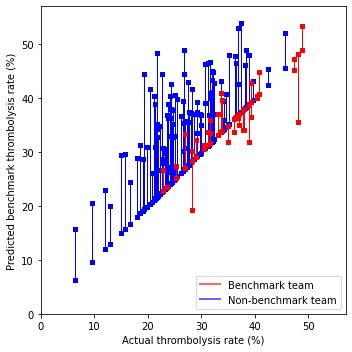

In [18]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

# Plot non-benchmark hospitals in blue
mask = hospital_benchmark_rates['benchmark'] == False
non_bench = hospital_benchmark_rates[mask]

for i, val in non_bench.iterrows():
    ax.plot([non_bench['actual_4hr_arrival'] * 100,
             non_bench['actual_4hr_arrival'] * 100],
            [non_bench['actual_4hr_arrival'] * 100,
             non_bench['benchmark_4hr_arrival'] * 100],
            color='b', lw=1, marker='o', alpha=0.6, markersize=4)

# Plot benchmark hospitals in red
mask = hospital_benchmark_rates['benchmark']
bench = hospital_benchmark_rates[mask]

for i, val in bench.iterrows():
    ax.plot([bench['actual_4hr_arrival'] * 100,
             bench['actual_4hr_arrival'] * 100],
            [bench['actual_4hr_arrival'] * 100,
             bench['benchmark_4hr_arrival'] * 100],
            color='r', lw=1, marker='o', alpha=0.6, markersize=4)


# Add mods 
ax.set_xlabel('Actual thrombolysis rate (%)')
ax.set_ylabel('Predicted benchmark thrombolysis rate (%)')
ax.set_xlim(0, 57)
ax.set_ylim(0, 57)

custom_lines = [Line2D([0], [0], color='r', alpha=0.6, lw=2),
                Line2D([0], [0], color='b', alpha = 0.6,lw=2)]

plt.legend(custom_lines, ['Benchmark team', 'Non-benchmark team'],
          loc='lower right')

plt.tight_layout()
plt.savefig('output/benchmark_thrombolysis.jpg', dpi=300)

plt.show()

### Calculated weighted average

Weight thrombolysis by admission numbers

In [19]:
base_4hr_arrival = ((hospital_benchmark_rates['count_4hr_arrival'] * 
                     hospital_benchmark_rates['actual_4hr_arrival']).sum() / 
                    hospital_benchmark_rates['count_4hr_arrival'].sum())

benchmark_4hr_arrival = ((hospital_benchmark_rates['count_4hr_arrival'] * 
                     hospital_benchmark_rates['benchmark_4hr_arrival']).sum() / 
                    hospital_benchmark_rates['count_4hr_arrival'].sum())

base_4hr_scan = ((hospital_benchmark_rates['count_4hr_scan'] * 
                     hospital_benchmark_rates['actual_4hr_scan']).sum() / 
                    hospital_benchmark_rates['count_4hr_scan'].sum())

benchmark_4hr_scan = ((hospital_benchmark_rates['count_4hr_scan'] * 
                     hospital_benchmark_rates['benchmark_4hr_scan']).sum() / 
                    hospital_benchmark_rates['count_4hr_scan'].sum())

In [20]:
print (f'Baseline thrombolysis onset-to-arrival of 4 hrs: {base_4hr_arrival*100:0.1f}')
print (f'Benchmark thrombolysis onset-to-arrival of 4 hrs: {benchmark_4hr_arrival*100:0.1f}')
ratio = benchmark_4hr_arrival / base_4hr_arrival
print (f'Benchmark thrombolysis ratio onset-to-arrival of 4 hrs: {ratio:0.3f}')
print ()
print (f'Baseline thrombolysis onset-to-scan of 4 hrs: {base_4hr_scan*100:0.1f}')
print (f'Benchmark thrombolysis onset-to-scan of 4 hrs: {benchmark_4hr_scan*100:0.1f}')
ratio = benchmark_4hr_scan / base_4hr_scan
print (f'Benchmark thrombolysis ratio onset-to-scan of 4 hrs: {ratio:0.3f}')

Baseline thrombolysis onset-to-arrival of 4 hrs: 29.5
Benchmark thrombolysis onset-to-arrival of 4 hrs: 36.9
Benchmark thrombolysis ratio onset-to-arrival of 4 hrs: 1.251

Baseline thrombolysis onset-to-scan of 4 hrs: 35.0
Benchmark thrombolysis onset-to-scan of 4 hrs: 43.8
Benchmark thrombolysis ratio onset-to-scan of 4 hrs: 1.250


## Observations

* A 'benchmark' set of hospitals was created by identifying those 30 hospitals whith the highest predicted thrombolysis use in a set cohort of patients.

* The benchmark hospitals were not necessarily the top thrombolysing hospitals given their own patient populations.

* If decision to treat were made according to a majority vote of the benchmark set of hospitals then thrombolysis use (in those arriving within 4 hours of known stroke onset) would be expected to increase from 29.5% to 36.9%.